<a href="https://colab.research.google.com/github/hybyun0121/gnn/blob/main/cs224w/what_is_torch_scatter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
print(TORCH)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
print(CUDA)

!pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

1.9.0
cu102
     |████████████████████████████████| 2.6MB 1.6MB/s 
     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 931kB 4.2MB/s 
     |████████████████████████████████| 389kB 5.0MB/s 
     |████████████████████████████████| 225kB 6.8MB/s 
     |████████████████████████████████| 235kB 8.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


In [3]:
import torch
import torch_scatter

import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data

In [16]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
edge_index = torch.tensor([[0,0,0,1,2,2,3,3],
                           [1,2,3,0,0,3,0,2]], dtype=torch.long)
x = torch.tensor([[10,10,10],
                  [11,11,11],
                  [12,12,12],
                  [13,13,13]], dtype=torch.float)

In [5]:
data = Data(x=x, edge_index=edge_index)

In [17]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

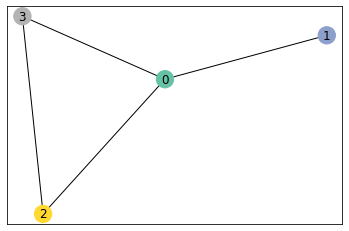

In [15]:
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                         node_color=range(x.shape[0]), cmap="Set2")

In [21]:
x

tensor([[10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.]])

In [25]:
inputs = torch.tensor([[10., 10., 10.],
                       [10., 10., 10.],
                       [10., 10., 10.],
                       [11., 11., 11.],
                       [12., 12., 12.],
                       [12., 12., 12.],
                       [13., 13., 13.],
                       [13., 13., 13.]])

In [30]:
index = edge_index[1]
print(index)

tensor([1, 2, 3, 0, 0, 3, 0, 2])


In [28]:
torch_scatter.scatter(src=inputs,
                      index=index,
                      dim=-2,
                      reduce='sum')

tensor([[36., 36., 36.],
        [10., 10., 10.],
        [23., 23., 23.],
        [22., 22., 22.]])

### torch_scatter.scatter의 내부 동작 원리 간단 설명
index_col에 같은 원소들끼리 대응되는 inputs의 원소들을 가지고 연산(sum or mena)을 수행합니다.  
그리고 index_col의 원소 값이 새로운 tensor의 index가 됩니다.  
아래 예시를 통해 좀 더 이해를 쉽게 할 수 있습니다.

In [59]:
# (v, u) 중 u 노드들만 일렬로 나타냅니다.
index_col = index.unsqueeze(-1)
index_col

tensor([[1],
        [2],
        [3],
        [0],
        [0],
        [3],
        [0],
        [2]])

In [60]:
# features 크기 만큼 확장시킵니다.
exp_index_col = index_col.expand_as(inputs)
exp_index_col

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [0, 0, 0],
        [0, 0, 0],
        [3, 3, 3],
        [0, 0, 0],
        [2, 2, 2]])

In [63]:
# shape이 (# of nodes, features) 인 zeor matrix 하나를 만들어줍니다.
out = torch.zeros(inputs.shape[0]//2, inputs.shape[1], dtype=inputs.dtype)
out

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [64]:
out.scatter_add_(-2, exp_index_col, inputs)

tensor([[36., 36., 36.],
        [10., 10., 10.],
        [23., 23., 23.],
        [22., 22., 22.]])